# House prices

Load data and packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings

from scipy.stats import norm
from scipy.stats.stats import pearsonr

sns.set(style='darkgrid', context='notebook', palette='deep')
warnings.filterwarnings('ignore')
%matplotlib inline

Load datasets train and test

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# Check datasets size
print(f"Train data size before drop Id column : {train.shape}")
print(f"Test data size before drop Id column : {test.shape}")

# Save column Id
train_id = train['Id']
test_id = test['Id']



Train data size before drop Id column : (1460, 81)
Test data size before drop Id column : (1459, 80)


In [4]:
# Drop column Id because it's useless for the process
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# Check datasets size after drop Id values
print(f"Train data size after drop Id column : {train.shape}")
print(f"Test data size after drop Id column : {test.shape}")

Train data size after drop Id column : (1460, 80)
Test data size after drop Id column : (1459, 79)


In [5]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Analyze target "SalePrice"

In [7]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Visualization

Text(0.5, 1.0, 'SalePrice distribution')

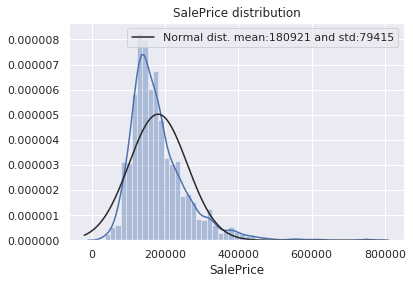

In [8]:
sns.distplot(train['SalePrice'], fit = norm)
(mean, std) = norm.fit(train['SalePrice'])
plt.legend([f"Normal dist. mean:{int(mean)} and std:{int(std)}"])
plt.title('SalePrice distribution')

In [9]:
skew = train['SalePrice'].skew()
kurt = train['SalePrice'].kurt()

print(f"Skewness: {skew}")
print(f"Kurtosis: {kurt}")

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


The skewness and the kurtosis show that the sale prices deviate from the normal distribution and that there is a peak.  
We want our data to be as normal as possible so we will try to fix this.

## Mutivariable analysis

We will split all features in two types :  
* Categorical
* Numerical

In [10]:
# Check categorical features
train.select_dtypes(include = ['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [11]:
# Check numerical features
train.select_dtypes(include = ['int64', 'float64']).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [12]:
# Count features by type
total_cat = len(train.select_dtypes(include = ['object']).columns)
total_num = len(train.select_dtypes(include = ['int64', 'float64']).columns)

print(f"{total_cat} categorical + {total_num} numerical = {total_cat + total_num} features")

43 categorical + 37 numerical = 80 features


### Correlation matrix heatmap

In [13]:
corrmat = train.corr()

In [14]:
corrmat

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.065649,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,...,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378


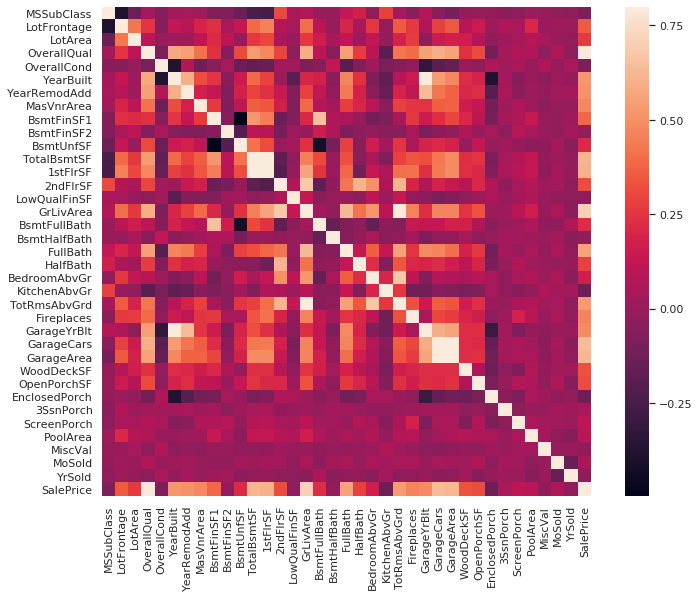

In [15]:
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat, vmax = .8, square = True)

Another Correlation Matrix with Top 10  features most related to Sale Price

In [16]:
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index

In [17]:
cols

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')

In [18]:
# Display correlation coeff
top_10_corrmat = train[cols].corr()

In [19]:
top_10_corrmat

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt
SalePrice,1.000000,0.790982,0.708624,0.640409,0.623431,0.613581,0.605852,0.560664,0.533723,0.522897
OverallQual,0.790982,1.000000,0.593007,0.600671,0.562022,0.537808,0.476224,0.550600,0.427452,0.572323
GrLivArea,0.708624,0.593007,1.000000,0.467247,0.468997,0.454868,0.566024,0.630012,0.825489,0.199010
GarageCars,0.640409,0.600671,0.467247,1.000000,0.882475,0.434585,0.439317,0.469672,0.362289,0.537850
GarageArea,0.623431,0.562022,0.468997,0.882475,1.000000,0.486665,0.489782,0.405656,0.337822,0.478954
TotalBsmtSF,0.613581,0.537808,0.454868,0.434585,0.486665,1.000000,0.819530,0.323722,0.285573,0.391452
1stFlrSF,0.605852,0.476224,0.566024,0.439317,0.489782,0.819530,1.000000,0.380637,0.409516,0.281986
FullBath,0.560664,0.550600,0.630012,0.469672,0.405656,0.323722,0.380637,1.000000,0.554784,0.468271
TotRmsAbvGrd,0.533723,0.427452,0.825489,0.362289,0.337822,0.285573,0.409516,0.554784,1.000000,0.095589
YearBuilt,0.522897,0.572323,0.199010,0.537850,0.478954,0.391452,0.281986,0.468271,0.095589,1.000000


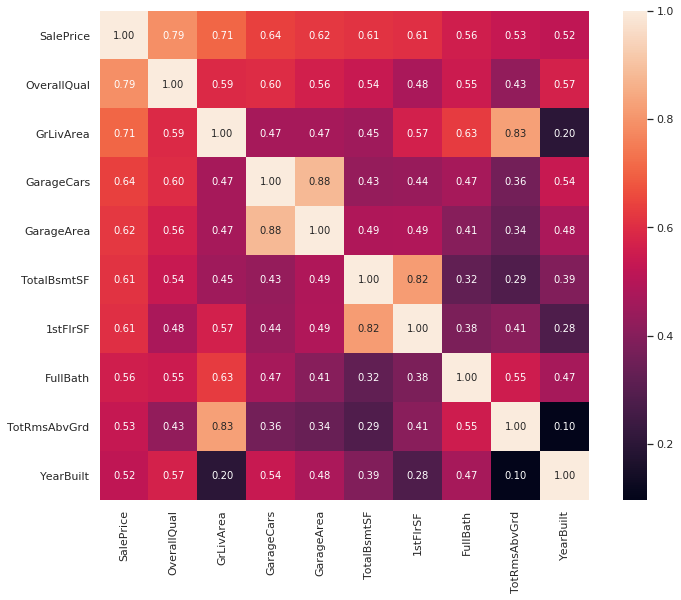

In [20]:
f, ax = plt.subplots(figsize = (12, 9))
top_10_heatmap = sns.heatmap(top_10_corrmat, 
                             annot = True, 
                             square = True, 
                             fmt = '.2f', 
                             annot_kws = {'size': 10},
                             yticklabels = cols.values,
                             xticklabels = cols.values
                            )

We create a dataframe of top 10 features most correlated to Sale Price

In [21]:
top_10_corrdf = pd.DataFrame(cols)
top_10_corrdf.columns = ['Most correlated Features']
top_10_corrdf

,Most correlated Features
0,SalePrice
1,OverallQual
2,GrLivArea
3,GarageCars
4,GarageArea
5,TotalBsmtSF
6,1stFlrSF
7,FullBath
8,TotRmsAbvGrd
9,YearBuilt


Let's compare each most correlated features with Sale Price

In [22]:
# OverallQual vs SalePrice

data = pd.concat([train['SalePrice'], train['OverallQual']], axis = 1)
data

,SalePrice,OverallQual
0,208500,7
1,181500,6
2,223500,7
3,140000,7
4,250000,8
...,...,...
1455,175000,6
1456,210000,6
1457,266500,7
1458,142125,5


For integer type features we will use boxplot  
For float type features we will use scatterplot with linear reg

#### OverallQual

(-0.5, 9.5, -1105.0, 800000)

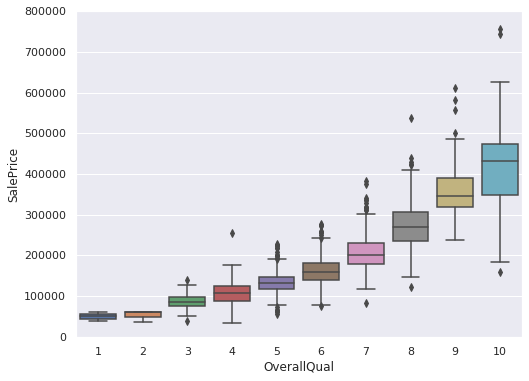

In [23]:
# Boxplot
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = data)
fig.axis(ymax=800000)

#### GrLivArea

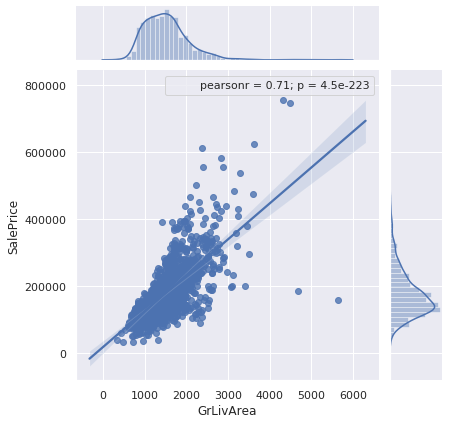

In [24]:
sns.jointplot(x=train['GrLivArea'], y = train['SalePrice'], kind='reg').annotate(pearsonr)

We can observe that for a larger GrLivArea the Sale Price increase which seems logical.  
We also see two outliers where the GrLivArea is very large but the price is low.  
Let's try to remove those two values.

In [25]:
# Remove outliers (two points where GrLivArea > 4000 and SalePrice < 200 000)
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 200000)].index).reset_index(drop=True)

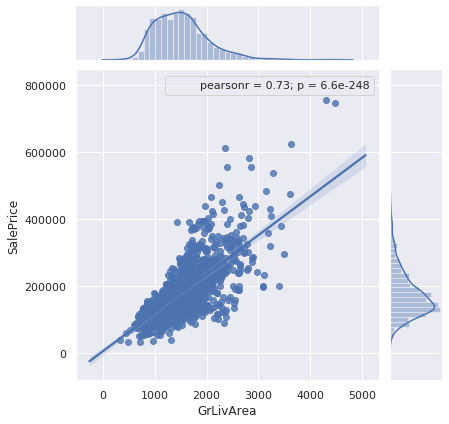

In [26]:
sns.jointplot(x=train['GrLivArea'], y = train['SalePrice'], kind='reg').annotate(pearsonr)


The correlation coefficient increases by 0.02 after removing outliers values

#### GarageCars 

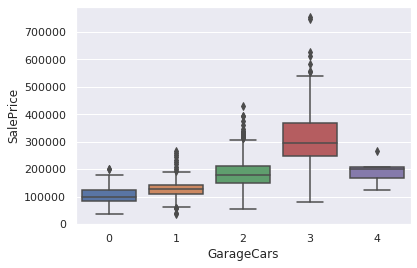

In [27]:
sns.boxplot(x = train['GarageCars'], y = train['SalePrice'])

We can observe the more cars you can park in your garage, the more the Sale Price is high.
After more than 3 places available in the garage, the Sale Price decrease which is not logical. So we will remove the outlier values were garageCars > 3 and SalePrice < 300 000

In [28]:
# Remove outliers (where GarageCars > 3 and SalePrice < 300 000)
train = train.drop(train[(train['GarageCars'] > 3) & (train['SalePrice'] < 300000)].index).reset_index(drop=True)

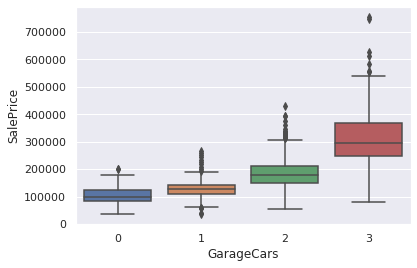

In [29]:
sns.boxplot(x = train['GarageCars'], y = train['SalePrice'])

#### GarageArea 

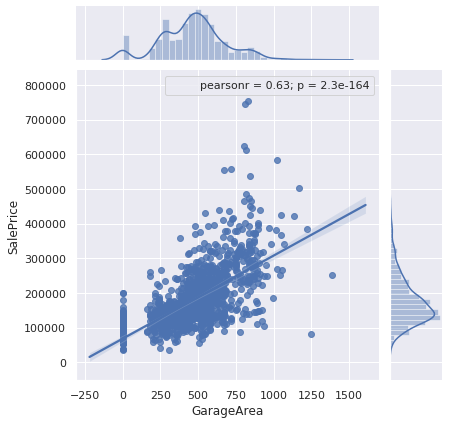

In [30]:
sns.jointplot(x=train['GarageArea'], y = train['SalePrice'], kind='reg').annotate(pearsonr)

Two outliers (GarageArea > 1200 and SalePrice < 300000)  
Let's remove this

In [31]:
train = train.drop(train[(train['GarageArea'] > 1200) & (train['SalePrice'] < 300000)].index).reset_index(drop=True)

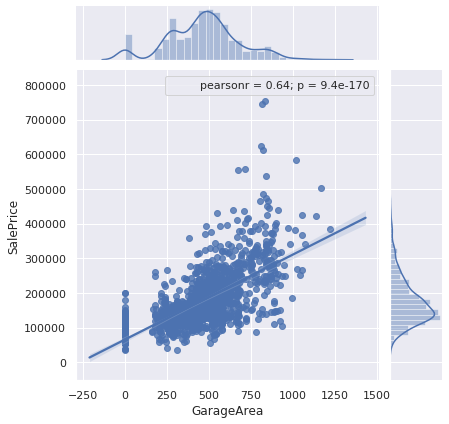

In [32]:
sns.jointplot(x=train['GarageArea'], y = train['SalePrice'], kind='reg').annotate(pearsonr)

We increase the correlation coefficient by 0.01 point

#### TotalBsmtSF

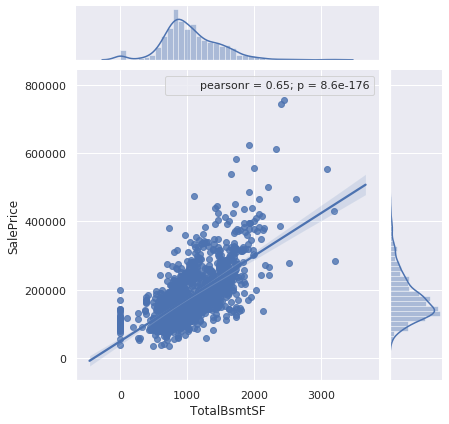

In [33]:
sns.jointplot(x=train['TotalBsmtSF'], y = train['SalePrice'], kind='reg').annotate(pearsonr)

We don't see any obvious outlier value here

#### 1stFlrSF

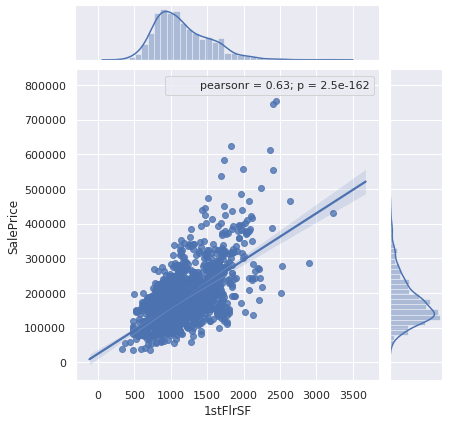

In [34]:
sns.jointplot(x=train['1stFlrSF'], y = train['SalePrice'], kind='reg').annotate(pearsonr)

Nothing here

#### TotRmsAbvGrd

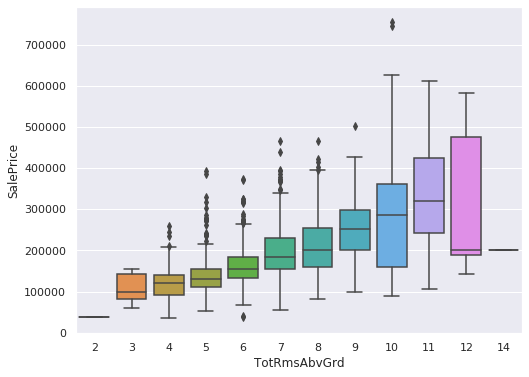

In [35]:
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x = train['TotRmsAbvGrd'], y = train['SalePrice'])

We can observe houses with more than 11 rooms are less expensive.  
It could be a price reduction offered by the real estate agent or an outlier.  
We will consider this as an outlier and remove those values.

In [36]:
train = train.drop(train[(train['TotRmsAbvGrd'] > 11) & (train['SalePrice'] < 300000)].index).reset_index(drop=True)

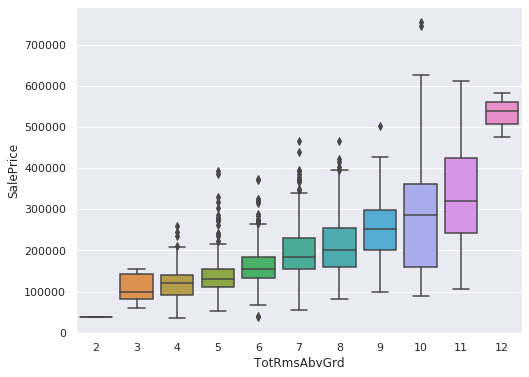

In [37]:
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x = train['TotRmsAbvGrd'], y = train['SalePrice'])

#### YearBuilt

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text xticklabel objects>)

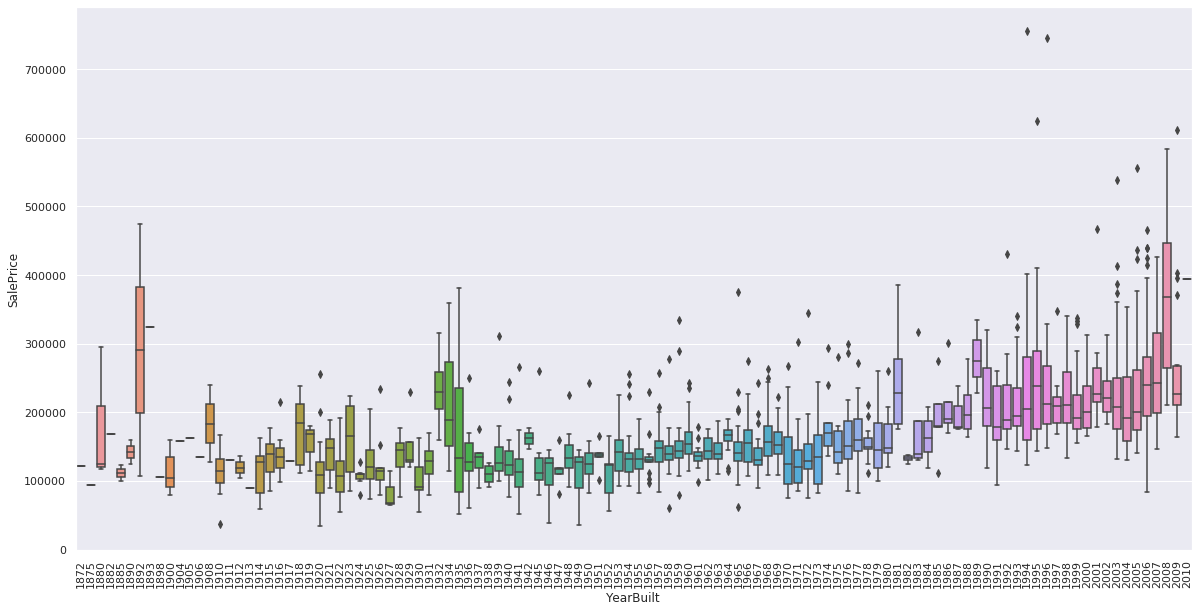

In [38]:
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x = train['YearBuilt'], y = train['SalePrice'])
plt.xticks(rotation = 90)

We cannot be sure if the High Sale Prices are a consequence of the inflation or crisis (1929, 1973, 2008) so we don't change anything here. 

## Handle missing Data and Clean Data

Is the missing important to predict Sale Price ?  
Is missing data random or does it have a pattern ?

Let's combine train and test data into one dataset to do some cleaning